In [1]:
###Import Packages###
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from skimage import io, color

import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

##Upload Data manually

In [2]:
!mkdir data/

Upload a image and drag it under data/

In [ ]:
# Unzip them if necessary
# !unzip /content/original_img.zip -d /content/data/
# !unzip /content/masked_img.zip -d /content/data/
# os.rename('/content/data/Images','/content/data/original_img')

In [24]:
def get_fnames(root):
  xs = os.listdir(os.path.join(root))
  f = lambda fname: int(fname.split('.png')[0])
  xs = sorted(xs, key=f)
#   ys = sorted(ys, key=f)
  return xs

# our dataset class
# rest_set_size = 0.3
# test_set_size = 0.3
class dset(Dataset):
    def __init__(self, data, root_dir='/content/data',transformX = None):
      self.root_dir = root_dir
      self.transformX = transformX
      # self.train = train
      self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        fname = self.data[index]

        imx_name = os.path.join(self.root_dir, fname)
        imx = Image.open(imx_name)
        # imy_name = os.path.join(self.root_dir, 'masked_img', fname)
        # imy = Image.open(imy_name).convert('L')
        

        if self.transformX:
            imx = self.transformX(imx)
            # imy = self.transformY(imy)

        sample = {'image': imx}
        return sample

tx_X = transforms.Compose([
                           transforms.Resize((512, 512)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])
# tx_Y = transforms.Compose([
#                               transforms.ToTensor()
#                               ])

test_data = get_fnames(root='data')

# split the dataset to train and test

# val_set = dset(val_data, 'data', transformX = tx_X, transformY = tx_Y)
test_set = dset(test_data, 'data', transformX = tx_X)

test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=True, num_workers=1)

In [25]:
# print(len(train_set))
# print(len(val_loader))
print(len(test_set))
print(len(test_loader))

1
1


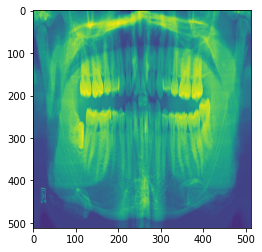

In [14]:
plt.imshow(test_set[0]['image'].squeeze(0))
plt.show()

# Import Best Model

Upload the best model manually

In [15]:
###try Res-Unet instead of original Unet
class res_conv(nn.Module):
    def __init__(self, input_channels, output_channels, down=True):
        super(res_conv, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(output_channels),
                                   nn.LeakyReLU(inplace = True),
                                   nn.Dropout(0.1),
                                 )
        self.conv2 = nn.Sequential(nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(output_channels),
                                   nn.LeakyReLU(inplace = True),
                                   nn.Dropout(0.1),
                                  )
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)+x1
        return x2

class start_conv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(start_conv, self).__init__()
        self.conv = res_conv(input_channels, output_channels)

    def forward(self, x):
        x = self.conv(x)
        return x


class down_conv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(down_conv, self).__init__()
        self.conv = nn.Sequential(nn.MaxPool2d(2),
                                  res_conv(input_channels, output_channels),)
    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(up_conv, self).__init__()
        self.up = nn.ConvTranspose2d(input_channels//2, input_channels//2, kernel_size=2, stride=2)
        self.conv = res_conv(input_channels, output_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff1 = x2.shape[2]-x1.shape[2]
        diff2 = x2.shape[3]-x1.shape[3]
        x1 = F.pad(x1, pad=(diff1//2, diff1-diff1//2, diff2//2, diff2-diff2//2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class stop_conv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(stop_conv, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=1),
                                 nn.Sigmoid())

    def forward(self, x):
        x = self.conv(x)
        return x

class ResUnet(nn.Module):
    def __init__(self):
        super(ResUnet, self).__init__()
        self.inc = start_conv(1, 64)
        self.down1 = down_conv(64, 128)
        self.down2 = down_conv(128, 256)
        self.down3 = down_conv(256, 512)
        self.down4 = down_conv(512, 512)
        self.up1 = up_conv(1024, 256)
        self.up2 = up_conv(512, 128)
        self.up3 = up_conv(256, 64)
        self.up4 = up_conv(128, 64)
        self.outc = stop_conv(64, 1)

    def forward(self, x):
        xin = self.inc(x)
        xd1 = self.down1(xin)
        xd2 = self.down2(xd1)
        xd3 = self.down3(xd2)
        xd4 = self.down4(xd3)
        xu1 = self.up1(xd4, xd3)
        xu2 = self.up2(xu1, xd2)
        xu3 = self.up3(xu2, xd1)
        xu4 = self.up4(xu3, xin)
        out = self.outc(xu4)
        return out

In [16]:
###Load Best Model
#Make sure to select GPU in Colab

model = ResUnet()
model.load_state_dict(torch.load('/content/best_unet_051722_v1.pth'))
if torch.cuda.is_available():
  torch.cuda.empty_cache()
  model = model.to('cuda')

#Apply Post-Process functions

In [18]:
def im_converterX(tensor):
    image = tensor.cpu().clone().detach().numpy() 
    image = image.transpose(1,2,0) 
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) 
    image = image.clip(0, 1)
    return image
def im_converterY(tensor):
    image = tensor.cpu().clone().detach().numpy() 
    image = image.transpose(1,2,0)
    image = image * np.array((1, 1, 1)) 
    image = image.clip(0, 1) 
    return image

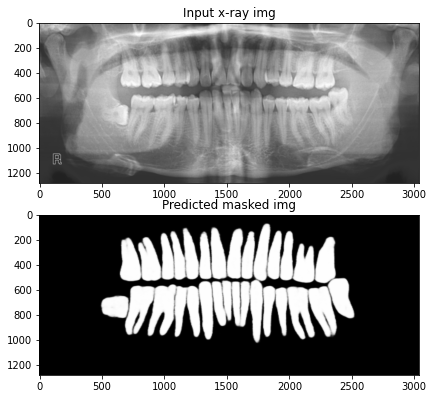

In [19]:
pig = plt.figure(figsize = (16, 10))
dim=3040,1280

for i, sample in enumerate(test_loader):
    # Xs, Ys = sample["image"], sample["annotation"]
    Xs=sample["image"]
    a = pig.add_subplot(3, 1, 1)
    imgx=im_converterX(Xs[0])
    imgx=cv2.resize(imgx, dim, interpolation = cv2.INTER_AREA)
    plt.title('Input x-ray img')
    plt.imshow(imgx)

    Xs = Xs.to("cuda")
    a = pig.add_subplot(3, 1, 2)
    output_img=im_converterY(model(Xs)[0])
    output_img=cv2.resize(output_img, dim, interpolation = cv2.INTER_AREA)
    plt.title('Predicted masked img')
    plt.imshow(output_img)

    # a = pig.add_subplot(3, 1, 3)
    # imgy=im_converterY(Ys[0])
    # imgy=cv2.resize(imgy, dim, interpolation = cv2.INTER_AREA)
    # plt.title('Actual masked img')
    # plt.imshow(imgy)
    break
plt.show()

In [21]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from imutils import perspective
from imutils import contours
from scipy.spatial import distance as dist

from skimage.segmentation import watershed
from skimage.measure import label
from skimage.color import label2rgb
from skimage import measure

In [34]:
path='/content/data/98.png' #change th path if file name is different

def inputShape(path):
  im=Image.open(path)
  w,h=im.size
  print((w,h))
  return (w,h)

dim=inputShape(path)

def ConnectedComp(img):
  # Load in image, convert to gray scale, and Otsu's threshold
  kernel =(np.ones((3,3), dtype=np.float32))
  # print(img.dtype)
  image=cv2.resize(img.astype(np.float32),dim)
  image=cv2.morphologyEx(image, cv2.MORPH_OPEN,kernel)
  
  # sharpen=np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
  # image=cv2.filter2D(image,-1,sharpen)
  
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  grayy = (gray*255*10).astype(np.uint8)
  thresh = cv2.threshold(grayy, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

  erosion = cv2.erode(thresh,kernel,iterations=3) #,iterations=2
  #gradient, aka the contours
  gradient = cv2.morphologyEx(erosion, cv2.MORPH_GRADIENT, kernel)

  ret,markers=cv2.connectedComponents(erosion,connectivity=8)
  new = watershed(erosion,markers,mask=thresh)
  RGB = label2rgb(new, bg_label=0)

  return erosion,gradient,RGB
  # return erosion
erosion,gradient,RGB=ConnectedComp(output_img)

(3094, 1150)


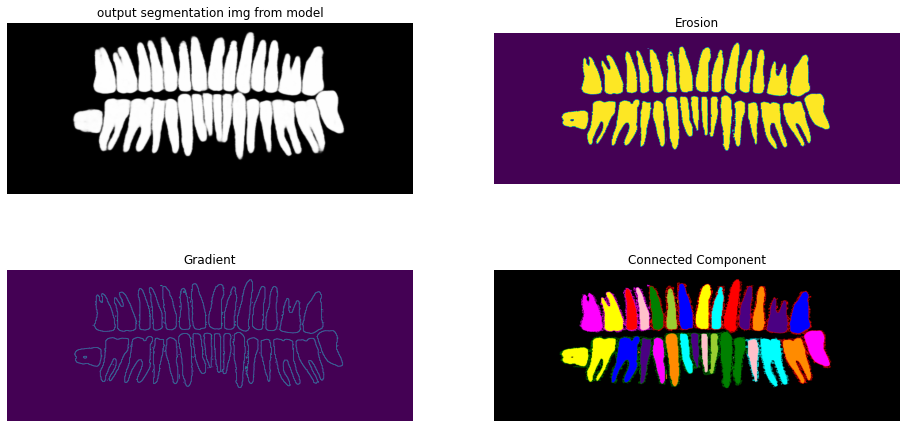

In [35]:
fig = plt.figure(figsize = (16,8))

ax = fig.add_subplot(2, 2, 1) 
plt.title('output segmentation img from model')
plt.axis('off')
plt.imshow(output_img)

ax = fig.add_subplot(2, 2, 2) 
plt.title('Erosion')
plt.axis('off')
plt.imshow(erosion)

ax = fig.add_subplot(2,2,3) 
plt.title('Gradient')
plt.axis('off')
plt.imshow(gradient)

ax = fig.add_subplot(2,2,4) 
plt.title('Connected Component')
plt.axis('off')
plt.imshow(RGB)

plt.show()